In [2]:
from Interval_v3 import *
import cv2
import json
import concurrent.futures
from itertools import repeat

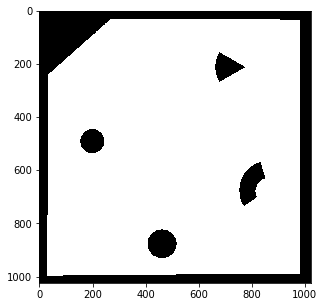

In [3]:
with open('obstacles.json') as f:   
    data = json.load(f)
obstacles = []
for obstacle in data['obstacles']:
    params,center = obstacle['params'],obstacle['center']
    obstacles.append(Interval(*params,center))
arena = cv2.imread("arena1.png")
arena = (1-cv2.cvtColor(arena,cv2.COLOR_RGB2GRAY)/255).astype('int')
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(arena,cmap = plt.cm.gray_r)
plt.show()
    

In [4]:
### no inheritance
class Robot:
    radius = 30
    bot_color = 'b'
    color = 'blue'
    Δt = 1
    obstacles = None
    Nr = 5
    Ntheta = 5
    Is = []
    
    def __init__(self,x_bot,y_bot,yaw,vi,vj,wi,wj):
        
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.yaw = yaw
        self.vi = vi
        self.vj = vj
        self.wi = wi
        self.wj = wj
        
    @property
    def interval(self):
        theta1 = self.yaw - (self.wi - self.wj)*self.Δt
        theta2 = self.yaw + (self.wi - self.wj)*self.Δt
        origin = (self.x_bot+self.radius*(np.cos(theta1)+np.cos(theta2))/(1e-6 + np.sin(theta1-theta2)),
                       self.y_bot+self.radius*(np.sin(theta1)+np.sin(theta2))/(1e-6 + np.sin(theta1-theta2)))

        n = self.radius/np.sin(1e-6+(theta2-theta1)/2)
        nu1 = n - self.radius
        nu2 = n + self.radius + (self.vi-self.vj)*self.Δt
        return Interval(nu1,nu2,theta1,theta2,origin)
    
    def __repr__(self):
        return f"Robot at {self.x_bot},{self.y_bot},{self.yaw}"
    
    def set_path(self,path):
        self.path = path
    
    def collision_detection(self):
        Js = []
        #### maybe multiprocessing here
#         with concurrent.futures.ProcessPoolExecutor() as executor:
#             Js = [executor.submit(super(Robot,self).interval_analysis,obstacle,5,5)for obstacle in self.obstacles]
            
#         for f in concurrent.futures.as_completed(Js):
#             print(f)
        
        for obstacle in self.obstacles:
            I = self.interval
            #print('obstacle', obstacle)
            J = I.fast_analysis(obstacle)
            #print("det", J)
            if not(J.r2 == 1e-6 and J.theta1 -J.theta2 == 0) :
                Js.append(J)
            del J       
        #print("obs", Js)
        return Js

    
    def generate_vw(self):
        min_angle = np.pi/24
        num_samples = np.ceil(((self.interval.theta2-self.interval.theta1)/min_angle)/2).astype('int')
        vws = []
        v = (self.interval.r2-self.interval.r1-2*self.radius)/self.Δt
        
        for i in range(num_samples):
            w = i*min_angle*self.Δt ### sus I.theta1+   
            vws.append([v,-1*w])
        for i in range(num_samples):
            w = i*min_angle*self.Δt ### sus I.theta1+
            vws.append([v,w])    
        return vws
            
    def collision_avoidance(self,Js,ax):
        """
        gives good v,w given bad v,w from the tracker
        """
#         w = w*np.random.uniform(-1,1)
        I = self.interval
        vws = self.generate_vw()
        comps = set([])
        for J in Js:
            comps.update(complement(I,J))    
        for comp in comps:
            comp.draw(ax,'magenta')
            if comp.r2 == I.r2:
                continue
            else:    
                for i,[v,w] in enumerate(vws):
                    if self.yaw+w*self.Δt<= comp.theta2+np.arcsin(self.radius/(I.r2-self.radius))+2*np.pi/24 and self.yaw+w*self.Δt>=comp.theta1-np.arcsin(self.radius/(I.r2-self.radius))-2*np.pi/24:
                        #np.pi/24 is min angle
                        vnew = ((comp.r2-comp.r1-2*self.radius)/self.Δt)
                        if v>vnew:
                            vws[i][0] = vnew*(vnew>=0)
                            
        print(comps)                  
                        
                    
                        
            
        idr = np.random.choice(range(len(vws)))
        #print(vws)
            
            
        vwes = np.array(vws)[::-1]
#         print(vws)
        vwn = vwes[np.argmax(vwes[:,:1])]
#         print("vwn = ",vwn)

        #return vws    
        return vwn
            
        
    
#     def __iter__(self):
#         return self
    
#     def __next__(self):
#         pose = [self.x_bot,self.y_bot,self.yaw]
#         Js = self.collision_detection()
#         v,w = self.collision_avoidance(Js)
#         self.x_bot += v*np.cos(self.yaw)*self.Δt
#         self.y_bot += v*np.sin(self.yaw)*self.Δt
#         self.yaw += w*self.Δt
# #         self.vj = v
# #         self.wj = w
#         super(Robot,self).__init__(*self.params)
        
        
#             #cook something that creates new v,w which do not crash into the obstacles 
#         #Robot(*pose,self.vi,self.vj,self.wi,self.wj)
#         return self
    def next_bot(self,ax):
        Js = self.collision_detection()
        v,w = self.collision_avoidance(Js,ax)
#         for J in Js:
#             J.draw(ax,'magenta')
        yaw = self.yaw + w*self.Δt
        x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
        y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
        self.yaw = yaw
        self.x_bot = x_bot
        self.y_bot = y_bot
        
        
#         vi = self.vi
#         vj = self.vj
#         wi = self.wi
#         wj = self.wj
        return self
    def next_bots(self,ax):
        bots = []
        Js = self.collision_detection()
        for [v,w] in self.collision_avoidance(Js,ax):
            yaw = self.yaw + w*self.Δt
            x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
            y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
            bots.append(Robot(x_bot,y_bot,yaw,self.vi,self.vj,self.wi,self.wj))
            
#         v,w = self.collision_avoidance(Js,ax)
#         for J in Js:
#             J.draw(ax,'magenta')
        
#         self.yaw = yaw
#         self.x_bot = x_bot
#         self.y_bot = y_bot
        
        
#         vi = self.vi
#         vj = self.vj
#         wi = self.wi
#         wj = self.wj
        return bots
            
        
        
    def plot(self,ax):
        bot_circle = plt.Circle( (self.x_bot, self.y_bot),self.radius,color=self.bot_color)
        arrow = ax.arrow(self.x_bot,self.y_bot,self.radius*np.cos(self.yaw),self.radius*np.sin(self.yaw))
        patch = ax.add_patch(bot_circle)
        return [bot_circle,arrow]
                           
    def plot_interval(self,ax):
#         for I in self.Is:
#             I.draw(ax,'green')
        self.interval.draw(ax,self.color)
        
    
    @classmethod
    def set_environment(cls,obstacles):
        cls.obstacles = obstacles
        
def correction(thetas):
    tuts = []
    for theta in thetas:
        if theta>=0 and theta<= np.pi/2:
            tuts.append(0)
        if theta>=3*np.pi/2 and theta<= 2*np.pi:
            tuts.append(1)

    if any(tuts) and not all(tuts):
        return [(theta-2*np.pi if theta>=3*np.pi/2 else theta) for theta in thetas]
    else:
        return thetas        
        
    
def complement(I,J):
    if J.r2 == 1e-6 and J.theta1 - J.theta2 == 0:
        return [I]
    I1 = Interval(I.r1,I.r2,*correction([I.theta1,J.theta1]),I.origin)
    I2 = Interval(I.r1,J.r1,*correction([J.theta1,J.theta2]),I.origin)
    I3 = Interval(I.r1,I.r2,*correction([J.theta2,I.theta2]),I.origin)
    return [I1,I2,I3]       

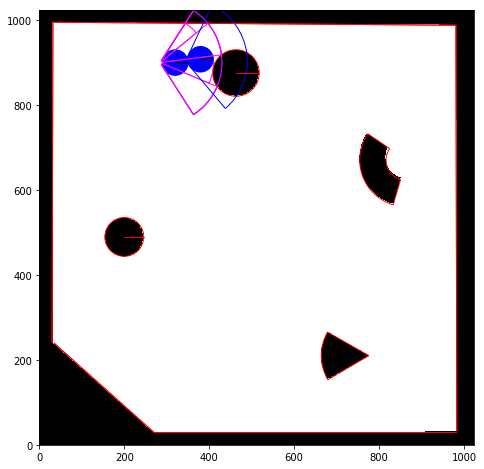

In [5]:

#robot = Robot(680,600,0,80,0,1.57,0)
#robot = Robot(800,800,0.5,100,0,1,0)
robot = Robot(320,900,0,80,0,1,0)
#robot = Robot(600,900,3.14,80,0,1,0)
#robot = Robot(900,800,4.2,100,0,1,0)
#robot = Robot(800,770,4.5,80,0,1,0)
#robot = Robot(400,400,0,100,0,1,0)
robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
#     obsa = obstacle
#     I = robot.interval
#     I.interval_analysis(obsa,5,5).draw(ax,"magenta")
    obstacle.draw(ax,'red')
#     del obsa
#     del I
robot.plot(ax)
robot.plot_interval(ax)

# print(robot.interval.gamma2.encloses(Point(obstacles[1].origin)))
# print("\n",obstacles[1].gamma2.encloses(Point(robot.interval.gamma2.origin)))
#robot.interval.fast_analysis(obstacles[1]).draw

# inters = intersection(robot.interval.gamma2.circle,obstacles[1].gamma2.circle)
# for inter in inters:
#     print(robot.interval.gamma2.encloses(inter))
#     print(obstacles[1].gamma2.encloses(inter))

for i in range(1):

    
    pose = robot.next_bot(ax)

    
    pose.plot(ax)
    pose.plot_interval(ax)
    robot = pose
    
    
#     for I in pose.Is:
#         I.draw(ax,'green')
    

# robot.collision_detection()


# pose1 = pose.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)
# pose1 = pose1.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)

# i = 0
# traj = []
# for pose in robot:
#     i+=1
#     for obstacle in obstacles:
#         obstacle.draw(ax,'red')
#     traj.append((pose.x_bot,pose.y_bot))    
#     pose.plot(ax)
#     pose.plot_interval(ax)
#     del pose
#     if i == 4:
#         break

# path = np.array(traj).T    
# ax.plot(path[0],path[1],'y-')

        

run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9


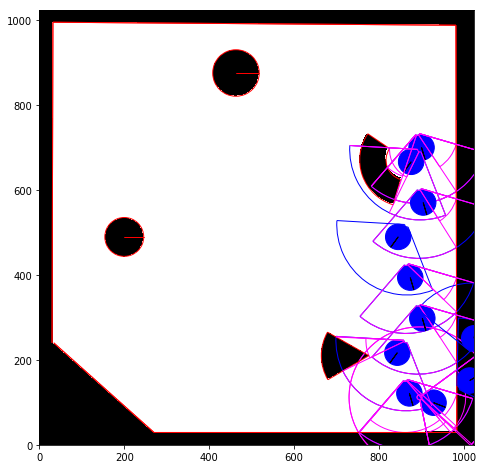

In [24]:

#robot = Robot(680,600,0,80,0,1,0)
#robot = Robot(800,800,0.5,100,0,1,0)
#robot = Robot(379.4084003997459, 907.8212642902986, 0.1308996938995747,80,0,1,0)
#robot = Robot(600,900,3.14,80,0,1,0)
#robot = Robot(900,700,5,100,0,1,0)
robot = Robot(200,600,0.5,100,0,1,0)
#robot = Robot(800,770,4.5,80,0,1,0)
#robot = Robot(400,400,0,100,0,1,0)
robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
#     obsa = obstacle
#     I = robot.interval
#     I.interval_analysis(obsa,5,5).draw(ax,"magenta")
    obstacle.draw(ax,'red')
#     del obsa
#     del I
robot.plot(ax)
robot.plot_interval(ax)

# print(robot.interval.gamma2.encloses(Point(obstacles[1].origin)))
# print("\n",obstacles[1].gamma2.encloses(Point(robot.interval.gamma2.origin)))
#robot.interval.fast_analysis(obstacles[1]).draw

# inters = intersection(robot.interval.gamma2.circle,obstacles[1].gamma2.circle)
# for inter in inters:
#     print(robot.interval.gamma2.encloses(inter))
#     print(obstacles[1].gamma2.encloses(inter))
log = []
for i in range(10):

    
    pose = robot.next_bot(ax)
    
    print("run:",i)
    log.append(f'run {i} :'+repr(pose))
    pose.plot(ax)
    pose.plot_interval(ax)
    robot = pose
    
    
#     for I in pose.Is:
#         I.draw(ax,'green')
    

# robot.collision_detection()


# pose1 = pose.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)
# pose1 = pose1.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)

# i = 0
# traj = []
# for pose in robot:
#     i+=1
#     for obstacle in obstacles:
#         obstacle.draw(ax,'red')
#     traj.append((pose.x_bot,pose.y_bot))    
#     pose.plot(ax)
#     pose.plot_interval(ax)
#     del pose
#     if i == 4:
#         break

# path = np.array(traj).T    
# ax.plot(path[0],path[1],'y-')

        

In [25]:
log


['run 0 :Robot at 875.528280271123,666.3436419610946,4.083702142702977',
 'run 1 :Robot at 903.8944988174457,570.4512144947807,5.0',
 'run 2 :Robot at 845.0861809162436,489.57116908411615,4.083702142702977',
 'run 3 :Robot at 873.4523994625663,393.6787416178023,5.0',
 'run 4 :Robot at 901.818618008889,297.78631415148845,5.0',
 'run 5 :Robot at 843.0103001076869,216.9062687408239,4.083702142702977',
 'run 6 :Robot at 871.3765186540096,121.01384127451004,5.0',
 'run 7 :Robot at 928.2657448644608,99.15206983924787,5.916297857297023',
 'run 8 :Robot at 1013.5489995023959,151.3705194366949,6.832595714594046',
 'run 9 :Robot at 1024.0384740533357,250.81885237217043,7.7488935718910685']

{Interval(5.651830281584495,145.6518302815845,0.6331125501174292,6.916297857297023,(894.9865438991565, 212.94082323800623)), Interval(5.651830281584495,145.6518302815845,-0.9230938962243309,4.916297857297023,(894.9865438991565, 212.94082323800623)), Interval(5.651830281584495,108.53787098884126,-0.9230938962243309,0.6331125501174292,(894.9865438991565, 212.94082323800623))}
run: 0
Interval(5.651830281584495,145.6518302815845,5.832595714594046,7.832595714594046,(966.0872544118359, 223.30996406342626))


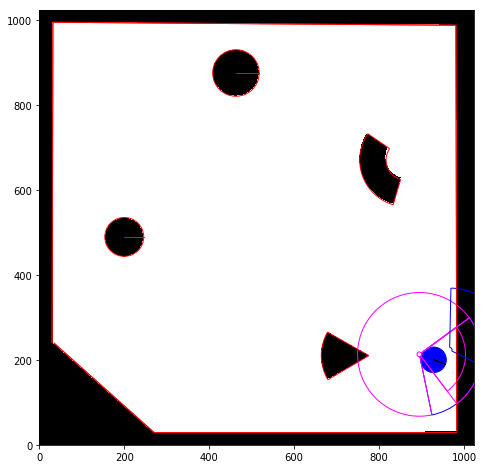

In [5]:

#robot = Robot(680,600,0,80,0,1,0)
#robot = Robot(800,800,0.5,100,0,1,0)
#robot = Robot(379.4084003997459, 907.8212642902986, 0.1308996938995747,80,0,1,0)
#robot = Robot(600,900,3.14,80,0,1,0)
robot = Robot(928.2657448644608,200.15206983924787,5.916297857297023,80,0,1,0)
#robot = Robot(800,770,4.5,80,0,1,0)
#robot = Robot(400,400,0,100,0,1,0)
robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
#     obsa = obstacle
#     I = robot.interval
#     I.interval_analysis(obsa,5,5).draw(ax,"magenta")
    obstacle.draw(ax,'red')
#     del obsa
#     del I
robot.plot(ax)
robot.plot_interval(ax)

# print(robot.interval.gamma2.encloses(Point(obstacles[1].origin)))
# print("\n",obstacles[1].gamma2.encloses(Point(robot.interval.gamma2.origin)))
#robot.interval.fast_analysis(obstacles[1]).draw

# inters = intersection(robot.interval.gamma2.circle,obstacles[1].gamma2.circle)
# for inter in inters:
#     print(robot.interval.gamma2.encloses(inter))
#     print(obstacles[1].gamma2.encloses(inter))
#log = []
for i in range(1):

    
    pose = robot.next_bot(ax)
    
    print("run:",i)
    #log.append(f'run {i} :'+repr(pose.interval))
    #pose.plot(ax)
    pose.plot_interval(ax)
    print(pose.interval)
    #robot = pose
    
    
#     for I in pose.Is:
#         I.draw(ax,'green')
    

# robot.collision_detection()


# pose1 = pose.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)
# pose1 = pose1.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)

# i = 0
# traj = []
# for pose in robot:
#     i+=1
#     for obstacle in obstacles:
#         obstacle.draw(ax,'red')
#     traj.append((pose.x_bot,pose.y_bot))    
#     pose.plot(ax)
#     pose.plot_interval(ax)
#     del pose
#     if i == 4:
#         break

# path = np.array(traj).T    
# ax.plot(path[0],path[1],'y-')

        ######################################################   patch up

In [23]:
print(log)

['run 0 :Interval(5.651830281584495,165.6518302815845,3.083702142702977,5.083702142702977,(896.4945584806408, 695.1789087090278))', 'run 1 :Interval(5.651830281584495,165.6518302815845,4.0,6.0,(893.7814051086044, 604.6386795370966))', 'run 2 :Interval(5.651830281584495,165.6518302815845,3.083702142702977,5.083702142702977,(866.0524591257614, 518.4064358320495))', 'run 3 :Interval(5.651830281584495,165.6518302815845,4.0,6.0,(863.3393057537251, 427.86620666011805))', 'run 4 :Interval(5.651830281584495,165.6518302815845,4.0,6.0,(891.7055243000477, 331.9737791938042))', 'run 5 :Interval(5.651830281584495,165.6518302815845,3.083702142702977,5.083702142702977,(863.9765783172047, 245.7415354887572))', 'run 6 :Interval(5.651830281584495,165.6518302815845,4.0,6.0,(861.2634249451684, 155.2013063168258))', 'run 7 :Interval(5.651830281584495,165.6518302815845,4.0,6.0,(889.629643491491, 59.30887885051195))', 'run 8 :Interval(5.651830281584495,165.6518302815845,4.916297857297023,6.916297857297023,(8

In [21]:
'aa' + repr(pose.interval)

'aaInterval(5.651830281584495,165.6518302815845,4.0,6.0,(893.7814051086044, 604.6386795370966))'

In [7]:
print(pose.x_bot,pose.y_bot,pose.yaw)

379.4084003997459 907.8212642902986 0.1308996938995747


In [8]:
robot.interval.theta1 - robot.interval.theta2

4.283185307179586

KeyboardInterrupt: 

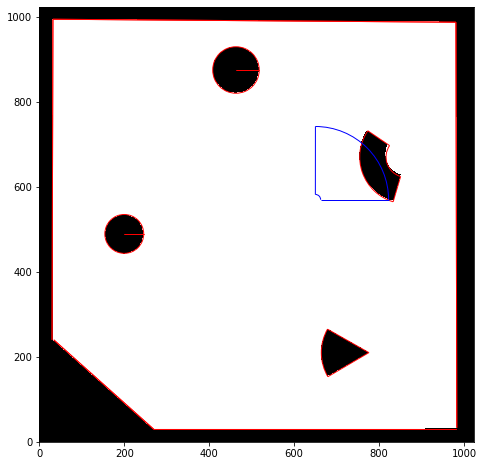

In [85]:
robot = Robot(680,600,0,100,0,1.57,0)
robot.set_environment(obstacles)

fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
traj = []
temp_bot = robot
for obstacle in obstacles:
        obstacle.draw(ax,'red')
for _ in range(3):
    
    traj.append((temp_bot.x_bot,temp_bot.y_bot))  
    for I in temp_bot.Is:
        I.draw(ax,'green')
    #temp_bot.plot(ax)
    temp_bot.plot_interval(ax)
    temp_bot = temp_bot.next_bot()
    
path = np.array(traj).T    
ax.plot(path[0],path[1],'y-')

In [ ]:
class PurePursuitTracker:
  
    def __init__(self, x, y, v, lookahead = 3.0):
        """
        Tracks the path defined by x, y at velocity v
        x and y must be numpy arrays
        v and lookahead are floats
        """
        self.length = len(x)
        self.ref_idx = 0 
        self.lookahead = lookahead
        self.x, self.y = x, y
        self.v, self.w = v, 0

    def update(self, xc, yc, theta):
        """
        Input: xc, yc, theta - current pose of the robot
        Update v, w based on current pose
        Returns True if trajectory is over.
        """
        if self.ref_idx >= self.length:
            ref_x,ref_y = self.x[-1],self.y[-1]
        else:  
            ref_x,ref_y = self.x[self.ref_idx],self.y[self.ref_idx]
        
        if self.ref_idx > self.length and np.sqrt((ref_x-self.x[-1])**2+ (ref_y-self.y[-1])**2) < goal_threshold: 
            return True           
        
        if np.sqrt((ref_x-xc)**2+ (ref_y-yc)**2) < lookahead:
            self.ref_idx += 1 
        
        anchor = np.asarray([ref_x - xc, ref_y - yc])

        theta = np.pi/2 - theta
        rot = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        anchor = np.dot(rot, anchor)
        
        L = np.sqrt(anchor[0] ** 2 + anchor[1] **2) # dist to reference path
        
        X = anchor[0] 
        
        self.w = -2*self.v*X/L/L

        return False


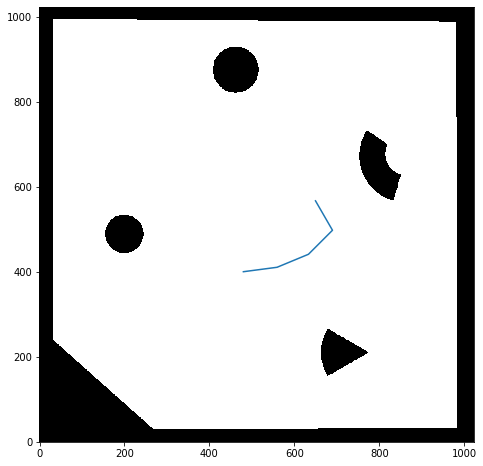

In [26]:
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')

p = np.array(traj).T    
ax.plot(p[0],p[1])
        

In [ ]:
x,y,t = 
tracker = PurePursuitTracker(x,y,vmax) 
pose = 0, 0, np.pi/2 #arbitrary initial pose
x0,y0,t0 = pose # record it for plotting

traj = []
while True:
    print("v = ",tracker.v," w = ",tracker.w)
    pose = simulate_unicycle(pose,tracker.v,tracker.w)

    if tracker.update(*pose):
        print("ARRIVED!!")    
        break
    traj.append([*pose, tracker.w, tracker.ref_idx]) 